# Exploratory Data Analysis on apartment datasset

## Goal

In this notebook, our objective is to transform the raw dataset into a clean, analysis-ready form for downstream regression modeling. Specifically, we will:

1. **Clean** the data by handling missing values and correcting data types.  
2. **Engineer** new features (e.g. log-transform skewed variables, encode categorical fields).  
3. **Scale** numerical features to ensure comparability and model stability.  
4. **distribution** sactter plot and sictribution of each variable and their realtion to target variable.
4. **Split** the final dataset into training and validation sets in accordance with the project requirements.  

By the end of the first 2 notebooks, we will have a fully preprocessed DataFrame that meets the criteria laid out in the project brief and is ready to feed into our regression algorithms.


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler



In [ ]:
df_test = pd.read_csv('/Users/majid/Documents/second semester/machine learning /_assessment_project/data/appartments_test.csv')
df = pd.read_csv('/Users/majid/Documents/second semester/machine learning /_assessment_project/data/appartments_train.csv')  # Replace with the correct filename

# Show basic info
print("\nFirst 5 rows:")
print(df.head())


First 5 rows:
            unit_id  obj_type  dim_m2  n_rooms  floor_no  floor_max  \
0  a3a463617a5c0439  0d6c4dfc   45.89      2.0       1.0        4.0   
1  23a92531fcb238b4  0c238f18   27.64      1.0       1.0        2.0   
2  d158671401f9fc34  0d6c4dfc   62.18      2.0       1.0        2.0   
3  280aced4655b7a96  2a6d5c01   53.68      2.0       NaN        4.0   
4  2315fa621e746fe4  2a6d5c01   70.89      3.0       2.0        3.0   

   year_built  dist_centre  n_poi  dist_sch  ...     price_z  src_month  \
0      1999.0       13.496   11.0     0.541  ...   519626.21    2023-09   
1      1940.0        2.440   16.0     0.377  ...   162959.26    2024-04   
2      2000.0       10.284    8.0     0.391  ...  1167571.51    2023-10   
3      2018.0       10.589   30.0     0.729  ...   907071.16    2024-01   
4      2015.0        8.305    7.0     1.226  ...  1080383.19    2023-11   

   loc_code  market_volatility  infrastructure_quality  \
0  693f303c          501710.76                   

In [144]:
# the structure of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156454 entries, 0 to 156453
Data columns (total 34 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   unit_id                     156454 non-null  object 
 1   obj_type                    122634 non-null  object 
 2   dim_m2                      156454 non-null  float64
 3   n_rooms                     156454 non-null  float64
 4   floor_no                    128756 non-null  float64
 5   floor_max                   154533 non-null  float64
 6   year_built                  130741 non-null  float64
 7   dist_centre                 156454 non-null  float64
 8   n_poi                       156454 non-null  float64
 9   dist_sch                    156324 non-null  float64
 10  dist_clinic                 155883 non-null  float64
 11  dist_post                   156266 non-null  float64
 12  dist_kind                   156291 non-null  float64
 13  dist_rest     

In [145]:

columns_with_missings = df.columns[df.isnull().any()]

# Print missing value counts
print("Missing value counts:\n")
print(df[columns_with_missings].isnull().sum())

Missing value counts:

obj_type                   33820
floor_no                   27698
floor_max                   1921
year_built                 25713
dist_sch                     130
dist_clinic                  571
dist_post                    188
dist_kind                    163
dist_rest                    391
dist_uni                    4317
dist_pharma                  219
build_mat                  61999
cond_class                117058
has_lift                    7727
infrastructure_quality     25713
dtype: int64


In [146]:
# Print frequency tables for each column
print("\nFrequency counts for columns with missing values:\n")
for column in columns_with_missings:
    print(f"\nFrequency counts for {column}:")
    print(df[column].value_counts(dropna=False))
    print("-" * 50)  # Add separator between columns


Frequency counts for columns with missing values:


Frequency counts for obj_type:
obj_type
0d6c4dfc    73136
NaN         33820
2a6d5c01    26001
0c238f18    23497
Name: count, dtype: int64
--------------------------------------------------

Frequency counts for floor_no:
floor_no
1.0     30396
NaN     27698
3.0     27034
2.0     26939
4.0     19173
5.0      7361
6.0      4481
7.0      3521
8.0      2710
9.0      2336
10.0     2224
11.0      902
12.0      508
14.0      334
13.0      258
15.0      206
17.0      155
16.0       92
20.0       25
18.0       25
24.0       19
29.0       14
23.0       14
22.0       11
25.0        6
21.0        6
19.0        5
27.0        1
Name: count, dtype: int64
--------------------------------------------------

Frequency counts for floor_max:
floor_max
4.0     48935
3.0     28889
5.0     15378
10.0    14002
2.0     12042
6.0      8590
7.0      5662
8.0      4533
11.0     4199
1.0      3556
9.0      2049
NaN      1921
12.0     1712
15.0     1176
17.0     

## Step-by-step detailed filling decision:

### Categorical
* obj_type → 'unknown_obj_type'

* build_mat → 'unknown_build_mat'

* cond_class → 'unknown_cond_class'

* has_lift → mode (df['has_lift'].mode()[0])

### Numeric
* floor_no → group-based imputation: fill based on floor_max or mode.

* floor_max → mode (most common: 4.0 floors).

* year_built → median year (about 1980).

* dist_clinic → median

* dist_uni → 5.0 km (safe larger default for missing university distance).

* infrastructure_quality → median (since related to age).

In [ ]:
# Fill categorical missing values
df['obj_type'] = df['obj_type'].fillna('unknown_obj_type')
df['build_mat'] = df['build_mat'].fillna('unknown_build_mat')
df['cond_class'] = df['cond_class'].fillna('unknown_cond_class')
df['has_lift'] = df['has_lift'].fillna(df['has_lift'].mode()[0])

# Fill floor_no based on floor_max where possible
# First simple strategy: If floor_no is missing, fill with half of floor_max (rounded)
floor_no_missing = df['floor_no'].isna()
df.loc[floor_no_missing, 'floor_no'] = (df.loc[floor_no_missing, 'floor_max'] / 2).round()

# Fill floor_no still missing (if floor_max was also missing)
df['floor_no'] = df['floor_no'].fillna(df['floor_no'].mode()[0])

# Fill floor_max with mode (most common value)
df['floor_max'] = df['floor_max'].fillna(df['floor_max'].mode()[0])

# Fill year_built with median year (ignoring extreme old years)
df['year_built'] = df['year_built'].fillna(df['year_built'].median())

# Fill distances
df['dist_clinic'] = df['dist_clinic'].fillna(df['dist_clinic'].median())
df['dist_uni'] = df['dist_uni'].fillna(5.0)

# Fill infrastructure_quality with median
df['infrastructure_quality'] = df['infrastructure_quality'].fillna(df['infrastructure_quality'].median())


In [148]:
# Print frequency tables for each column
print("\nFrequency counts for columns with missing values after imputation:\n")
for column in columns_with_missings:
    print(f"\nFrequency counts for {column}:")
    print(df[column].value_counts(dropna=False))
    print("-" * 50)  # Add separator between columns


Frequency counts for columns with missing values after imputation:


Frequency counts for obj_type:
obj_type
0d6c4dfc            73136
unknown_obj_type    33820
2a6d5c01            26001
0c238f18            23497
Name: count, dtype: int64
--------------------------------------------------

Frequency counts for floor_no:
floor_no
2.0     45935
1.0     33759
3.0     28090
4.0     20359
5.0      8665
6.0      4898
7.0      3530
8.0      2803
9.0      2341
10.0     2229
0.0      1264
11.0      902
12.0      508
14.0      334
13.0      258
15.0      206
17.0      155
16.0       92
20.0       25
18.0       25
24.0       19
29.0       14
23.0       14
22.0       11
25.0        6
21.0        6
19.0        5
27.0        1
Name: count, dtype: int64
--------------------------------------------------

Frequency counts for floor_max:
floor_max
4.0     50856
3.0     28889
5.0     15378
10.0    14002
2.0     12042
6.0      8590
7.0      5662
8.0      4533
11.0     4199
1.0      3556
9.0      2049
12

In [149]:
# Verify imputation by checking for remaining NaN values
print("NaN counts after imputation:")
print(df.columns.isna().sum())


NaN counts after imputation:
0


In [150]:
# Verify imputation by checking for remaining NaN values
print("NaN counts after imputation:")
print(df_test.columns.isna().sum())

NaN counts after imputation:
0


# Distributions of nominal variables

In [151]:
# Lets check the frequencies of individual levels of all the nominal variables

# Based on the information about the dataset we can list all nominal variables

nominal_variables = ['obj_type', 'own_type', 'build_mat', 'cond_class', 'has_park',
                     'has_balcony', 'has_lift', 'has_sec', 'has_store',
                     'src_month', 'loc_code']

# Loop through each nominal variable
for var in nominal_variables:
    # Get the value counts for each category in the variable
    value_counts = df[var].value_counts()
    print("\n")
    print(df[var].value_counts(dropna = False))



obj_type
0d6c4dfc            73136
unknown_obj_type    33820
2a6d5c01            26001
0c238f18            23497
Name: count, dtype: int64


own_type
12631efb    140897
bfb8fe10     15548
4e625087         9
Name: count, dtype: int64


build_mat
7ceffe3b             73414
unknown_build_mat    61999
7f8c00f9             21041
Name: count, dtype: int64


cond_class
unknown_cond_class    117058
a2881958               22298
53cced8d               17098
Name: count, dtype: int64


has_park
no     113938
yes     42516
Name: count, dtype: int64


has_balcony
yes    89655
no     66799
Name: count, dtype: int64


has_lift
no     82407
yes    74047
Name: count, dtype: int64


has_sec
no     138878
yes     17576
Name: count, dtype: int64


has_store
no     88578
yes    67876
Name: count, dtype: int64


src_month
2024-06    17213
2024-05    16306
2024-04    15319
2023-08    15003
2024-03    13865
2023-09    13637
2023-10    13402
2023-12    13200
2023-11    13106
2024-02    13033
2024-01    12370

In [152]:
# Loop through each nominal variable
for var in nominal_variables:
    
    value_counts = df[var].value_counts()
    # Identify the levels with counts not higher than 9
    levels_to_replace = value_counts[value_counts <= 9].index
    # Replace these levels with "Other"
    df[var] = df[var].replace(levels_to_replace, "Other")

In [153]:
# Loop through each nominal variable
for var in nominal_variables:
    # Get the value counts for each category in the variable
    value_counts = df[var].value_counts()
    print("\n")
    print(df[var].value_counts(dropna = False))



obj_type
0d6c4dfc            73136
unknown_obj_type    33820
2a6d5c01            26001
0c238f18            23497
Name: count, dtype: int64


own_type
12631efb    140897
bfb8fe10     15548
Other            9
Name: count, dtype: int64


build_mat
7ceffe3b             73414
unknown_build_mat    61999
7f8c00f9             21041
Name: count, dtype: int64


cond_class
unknown_cond_class    117058
a2881958               22298
53cced8d               17098
Name: count, dtype: int64


has_park
no     113938
yes     42516
Name: count, dtype: int64


has_balcony
yes    89655
no     66799
Name: count, dtype: int64


has_lift
no     82407
yes    74047
Name: count, dtype: int64


has_sec
no     138878
yes     17576
Name: count, dtype: int64


has_store
no     88578
yes    67876
Name: count, dtype: int64


src_month
2024-06    17213
2024-05    16306
2024-04    15319
2023-08    15003
2024-03    13865
2023-09    13637
2023-10    13402
2023-12    13200
2023-11    13106
2024-02    13033
2024-01    12370

# Near-zero variance


In [155]:
# lets define a function checking near-zero variance
def near_zero_var(df, freq_cut=95/5, unique_cut=10):
    """
    Identifies columns with near-zero variance in a DataFrame and calculates indicators.

    Parameters:
    - df (pd.DataFrame): Input DataFrame.
    - freq_cut (float): Threshold for the frequency ratio (default = 95/5).
    - unique_cut (int): Threshold for the unique value ratio (default = 10).

    Returns:
    - pd.DataFrame: A sorted DataFrame containing:
        - variable: Column name
        - freq_ratio: Ratio of the most common value to the second most common value
        - unique_ratio: Ratio of unique values to total observations
        - high_freq_ratio: Binary indicator (1 if freq_ratio > freq_cut)
        - low_unique_ratio: Binary indicator (1 if unique_ratio < unique_cut)
    """
    results = []

    for col in df.columns:
        # Get the value counts
        counts = df[col].value_counts()

        # Calculate freq_ratio
        if len(counts) > 1:
            freq_ratio = counts.iloc[0] / counts.iloc[1]
        else:
            freq_ratio = float('inf')  # Only one unique value

        # Calculate unique_ratio
        unique_ratio = len(counts) / len(df)

        # Determine binary indicators
        high_freq_ratio = int(freq_ratio > freq_cut)
        low_unique_ratio = int(unique_ratio < unique_cut)

        # Append results
        results.append({
            'variable': col,
            'freq_ratio': freq_ratio,
            'unique_ratio': unique_ratio,
            'high_freq_ratio': high_freq_ratio,
            'low_unique_ratio': low_unique_ratio
        })

    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)

    # Sort by 'high_freq_ratio' (descending) and 'low_unique_ratio' (ascending)
    results_df = results_df.sort_values(by=['freq_ratio', 'unique_ratio'], ascending=[False, True])

    return results_df


In [156]:
# and apply it to ALL VARIABLES from our dataset

apartment_nzv = near_zero_var(df, freq_cut=97/3, unique_cut=10)

apartment_nzv[(apartment_nzv['low_unique_ratio'] == 1) & (apartment_nzv['high_freq_ratio'] == 1)]





,variable,freq_ratio,unique_ratio,high_freq_ratio,low_unique_ratio
14,dist_uni,34.822581,0.035397,1,1


In [157]:
# lets check the first one - Pool_Area
df['dist_uni'].value_counts()

dist_uni
5.000    4318
0.485     124
0.588     110
0.523     110
0.323     109
         ... 
5.415       1
4.860       1
4.617       1
5.621       1
5.310       1
Name: count, Length: 5538, dtype: int64

In [158]:
# lets remove problematic variables from the dataset

variables_nzv = apartment_nzv[(apartment_nzv['low_unique_ratio'] == 1) & (apartment_nzv['high_freq_ratio'] == 1)]['variable']

print(variables_nzv)

df.drop(variables_nzv, axis = 1, inplace = True)

14    dist_uni
Name: variable, dtype: object



Data types:
unit_id                        object
obj_type                       object
dim_m2                        float64
n_rooms                       float64
floor_no                      float64
floor_max                     float64
year_built                    float64
dist_centre                   float64
n_poi                         float64
dist_sch                      float64
dist_clinic                   float64
dist_post                     float64
dist_kind                     float64
dist_rest                     float64
dist_pharma                   float64
own_type                       object
build_mat                      object
cond_class                     object
has_park                       object
has_balcony                    object
has_lift                       object
has_sec                        object
has_store                      object
price_z                       float64
src_month                      object
loc_code                       object

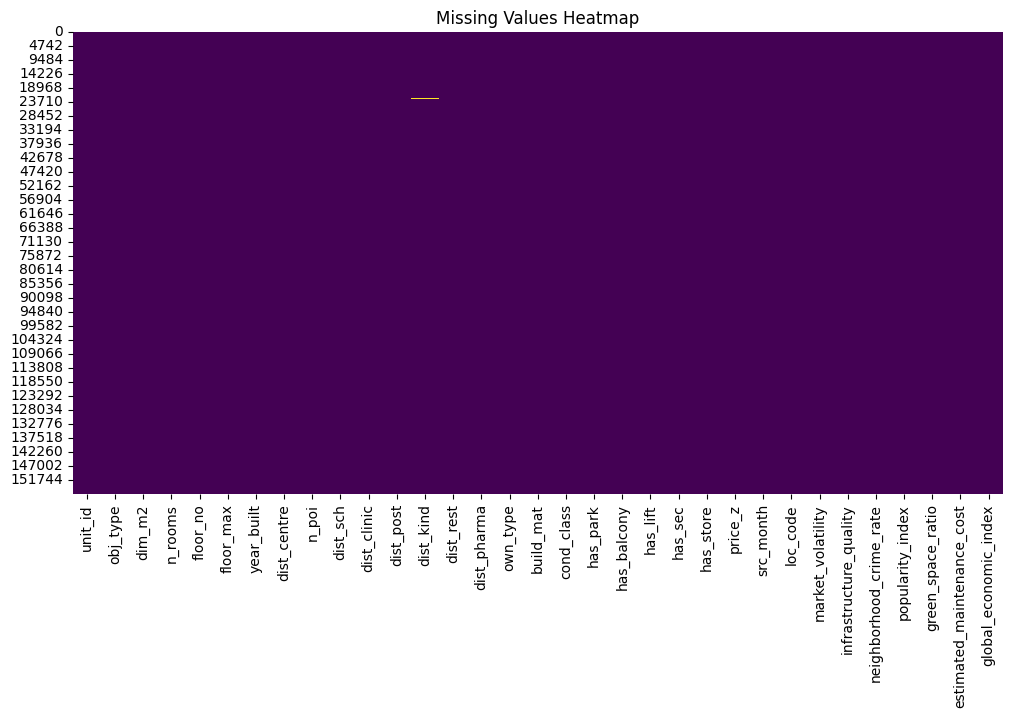

In [ ]:
# Data types of each column
print("\nData types:")
print(df.dtypes)

# Visualizing missing values
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.show()


# Distribution of the dependent variable

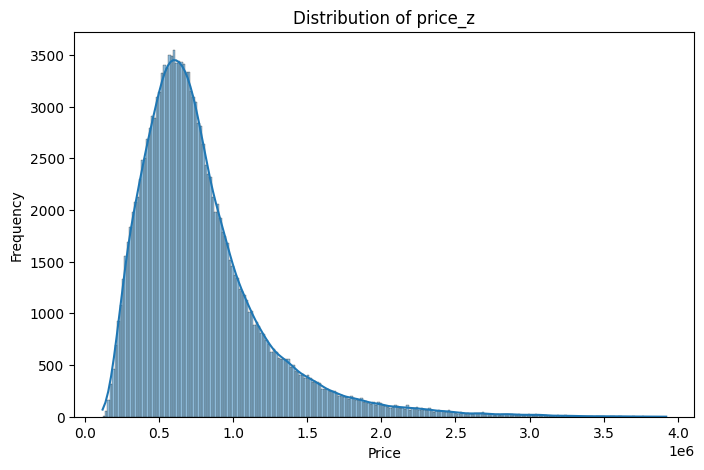

In [160]:
# Histogram of the target
plt.figure(figsize=(8, 5))
sns.histplot(df['price_z'], kde=True)
plt.title('Distribution of price_z')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()



<Axes: xlabel='price_z', ylabel='Count'>

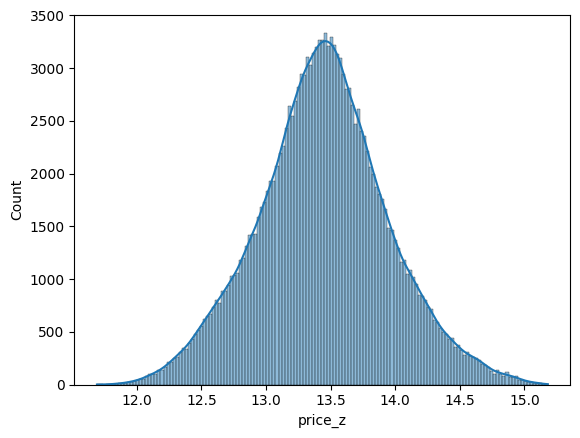

In [161]:
# Create a new object for the log-transformed Sale_Price 
Price_z_Log = np.log(df["price_z"] + 1)

sns.histplot(Price_z_Log, kde = True)

# much more "normal-like" - probably better for modelling

# Levels of numerical variables

In [162]:
numeric_variables = df.select_dtypes(include=[np.number]).columns

for col in numeric_variables:
    unique_vals = df[col].unique()
    n_unique = len(unique_vals)
    print(f"Column '{col}' has {n_unique} unique values.")

    # If a variable has no more than 5 unique values, print a frequency table
    if n_unique <= 5:
        print(f"Frequency table for '{col}':")
        print(df[col].value_counts(dropna = False), "\n")

Column 'dim_m2' has 12282 unique values.
Column 'n_rooms' has 6 unique values.
Column 'floor_no' has 28 unique values.
Column 'floor_max' has 29 unique values.
Column 'year_built' has 165 unique values.
Column 'dist_centre' has 13483 unique values.
Column 'n_poi' has 195 unique values.
Column 'dist_sch' has 3613 unique values.
Column 'dist_clinic' has 4908 unique values.
Column 'dist_post' has 3801 unique values.
Column 'dist_kind' has 3574 unique values.
Column 'dist_rest' has 3557 unique values.
Column 'dist_pharma' has 3583 unique values.
Column 'price_z' has 156331 unique values.
Column 'market_volatility' has 156356 unique values.
Column 'infrastructure_quality' has 15190 unique values.
Column 'neighborhood_crime_rate' has 10001 unique values.
Column 'popularity_index' has 6095 unique values.
Column 'green_space_ratio' has 3 unique values.
Frequency table for 'green_space_ratio':
green_space_ratio
1.000    98290
0.999    57806
0.998      358
Name: count, dtype: int64 

Column 'est

'n_rooms' , green_space_ratio , 'floor_no' , 'floor_max' has only few levels 

In [163]:
print(df.describe())

              dim_m2        n_rooms       floor_no      floor_max  \
count  156454.000000  156454.000000  156454.000000  156454.000000   
mean       58.702447       2.678634       3.122707       5.296739   
std        23.278725       0.916015       2.394167       3.294439   
min        18.780000       1.000000       0.000000       1.000000   
25%        42.240000       2.000000       2.000000       3.000000   
50%        54.240000       3.000000       2.000000       4.000000   
75%        69.820000       3.000000       4.000000       6.000000   
max       187.310000       6.000000      29.000000      29.000000   

          year_built    dist_centre          n_poi       dist_sch  \
count  156454.000000  156454.000000  156454.000000  156324.000000   
mean     1987.323590       4.357027      20.611509       0.413302   
std        31.032818       2.900580      24.212745       0.469380   
min      1850.000000       0.008000       0.000000       0.002000   
25%      1970.000000       2.0000

# Levels of ordinal variables

In [164]:
# List of ordinal variables based on the dataset description
# (remember that Utilities, Pool_QC and Functional columns were already removed)

ordinal_variables = [
    'floor_no', 'floor_max', 'n_rooms', 'has_park', 'has_balcony', 'has_lift',
    'has_sec', 'has_store', 'src_month'
]

for col in ordinal_variables:
    unique_vals = df[col].unique()
    n_unique = len(unique_vals)
    print(f"Column '{col}' has {n_unique} unique values.")
    print(f"Frequency table for '{col}':")
    print(df[col].value_counts(dropna = False), "\n")

Column 'floor_no' has 28 unique values.
Frequency table for 'floor_no':
floor_no
2.0     45935
1.0     33759
3.0     28090
4.0     20359
5.0      8665
6.0      4898
7.0      3530
8.0      2803
9.0      2341
10.0     2229
0.0      1264
11.0      902
12.0      508
14.0      334
13.0      258
15.0      206
17.0      155
16.0       92
20.0       25
18.0       25
24.0       19
29.0       14
23.0       14
22.0       11
25.0        6
21.0        6
19.0        5
27.0        1
Name: count, dtype: int64 

Column 'floor_max' has 29 unique values.
Frequency table for 'floor_max':
floor_max
4.0     50856
3.0     28889
5.0     15378
10.0    14002
2.0     12042
6.0      8590
7.0      5662
8.0      4533
11.0     4199
1.0      3556
9.0      2049
12.0     1712
15.0     1176
17.0      930
16.0      790
13.0      691
14.0      548
18.0      191
23.0      111
19.0      106
24.0       97
22.0       84
20.0       61
25.0       58
27.0       53
29.0       35
26.0       24
28.0       18
21.0       13
Name: cou

## Encoding **ordinal(categorical)** variables

In [165]:
# Boolean variables
bool_cols = ['has_park', 'has_balcony', 'has_lift', 'has_sec', 'has_store']
for col in bool_cols:
    df[col] = df[col].map({'no': 0, 'yes': 1})


# Ordinal month encoding
df['src_month'] = pd.to_datetime(df['src_month'], format="%Y-%m").dt.month

# Treat cond_class as nominal
df = pd.get_dummies(df, columns=['cond_class'], dummy_na=True)


## Encoding **nominal** variables

In [166]:
# Convert its index (the variable names) to a plain Python list:
list_nzv = list(apartment_nzv.index)

In [ ]:
# If list_nzv is already a list:
nzv_list = list_nzv  

# If list_nzv had been a pandas Series or Index, you’d do:
# nzv_list = list(list_nzv)

nominal_variables_left = [
    var
    for var in nominal_variables
    if var in df.columns and var not in nzv_list
]

print("Encoding these columns:", nominal_variables_left)

# 2. One-hot encode on train (df) and test (df_test):
# ——————————————————————————————————
df = pd.get_dummies(
    df,
    columns=nominal_variables_left,
    drop_first=True,
    dtype=int
)

df_test = pd.get_dummies(
    df_test,
    columns=nominal_variables_left,
    drop_first=True,
    dtype=int
)

# 3. Align test → train columns so they match exactly:
# ————————————————————————————————————————
df_test = df_test.reindex(columns=df.columns, fill_value=0)


Encoding these columns: ['obj_type', 'own_type', 'build_mat', 'has_park', 'has_balcony', 'has_lift', 'has_sec', 'has_store', 'src_month', 'loc_code']


In [ ]:
print(df.columns)
print(df_test.columns)

Index(['unit_id', 'dim_m2', 'n_rooms', 'floor_no', 'floor_max', 'year_built',
       'dist_centre', 'n_poi', 'dist_sch', 'dist_clinic', 'dist_post',
       'dist_kind', 'dist_rest', 'dist_pharma', 'price_z', 'market_volatility',
       'infrastructure_quality', 'neighborhood_crime_rate', 'popularity_index',
       'green_space_ratio', 'estimated_maintenance_cost',
       'global_economic_index', 'cond_class_53cced8d', 'cond_class_a2881958',
       'cond_class_unknown_cond_class', 'cond_class_nan', 'obj_type_0d6c4dfc',
       'obj_type_2a6d5c01', 'obj_type_unknown_obj_type', 'own_type_Other',
       'own_type_bfb8fe10', 'build_mat_7f8c00f9',
       'build_mat_unknown_build_mat', 'has_park_1', 'has_balcony_1',
       'has_lift_1', 'has_sec_1', 'has_store_1', 'src_month_2', 'src_month_3',
       'src_month_4', 'src_month_5', 'src_month_6', 'src_month_8',
       'src_month_9', 'src_month_10', 'src_month_11', 'src_month_12',
       'loc_code_143768f7', 'loc_code_378f340c', 'loc_code_3cb4aaf

In [ ]:
print(df.isna().sum())

unit_id              0
dim_m2               0
n_rooms              0
floor_no             0
floor_max            0
                    ..
loc_code_81b10147    0
loc_code_8d5a4f0c    0
loc_code_a6d54bd1    0
loc_code_e0cff11b    0
loc_code_ece39f3d    0
Length: 62, dtype: int64


In [170]:
print(df.columns.isna().sum())
print(df_test.columns.isna().sum())

0
0


### systematic audit of missing values (and extreme outliers)

#### Tabulate missing counts & percentages

In [171]:
missing = df.isna().sum().sort_values(ascending=False)
pct   = (missing / len(df) * 100).round(2)
pd.DataFrame({'missing_count': missing, 'percent_missing': pct})

,missing_count,percent_missing
dist_rest,391,0.25
dist_pharma,219,0.14
dist_post,188,0.12
dist_kind,163,0.10
dist_sch,130,0.08
...,...,...
obj_type_unknown_obj_type,0,0.00
own_type_Other,0,0.00
own_type_bfb8fe10,0,0.00
dim_m2,0,0.00


 **Great- I identified that only the “distance” variables have any missingness (all under 0.3%), which is actually pretty manageable.**

### Visualize the missingness pattern

<Figure size 800x400 with 0 Axes>

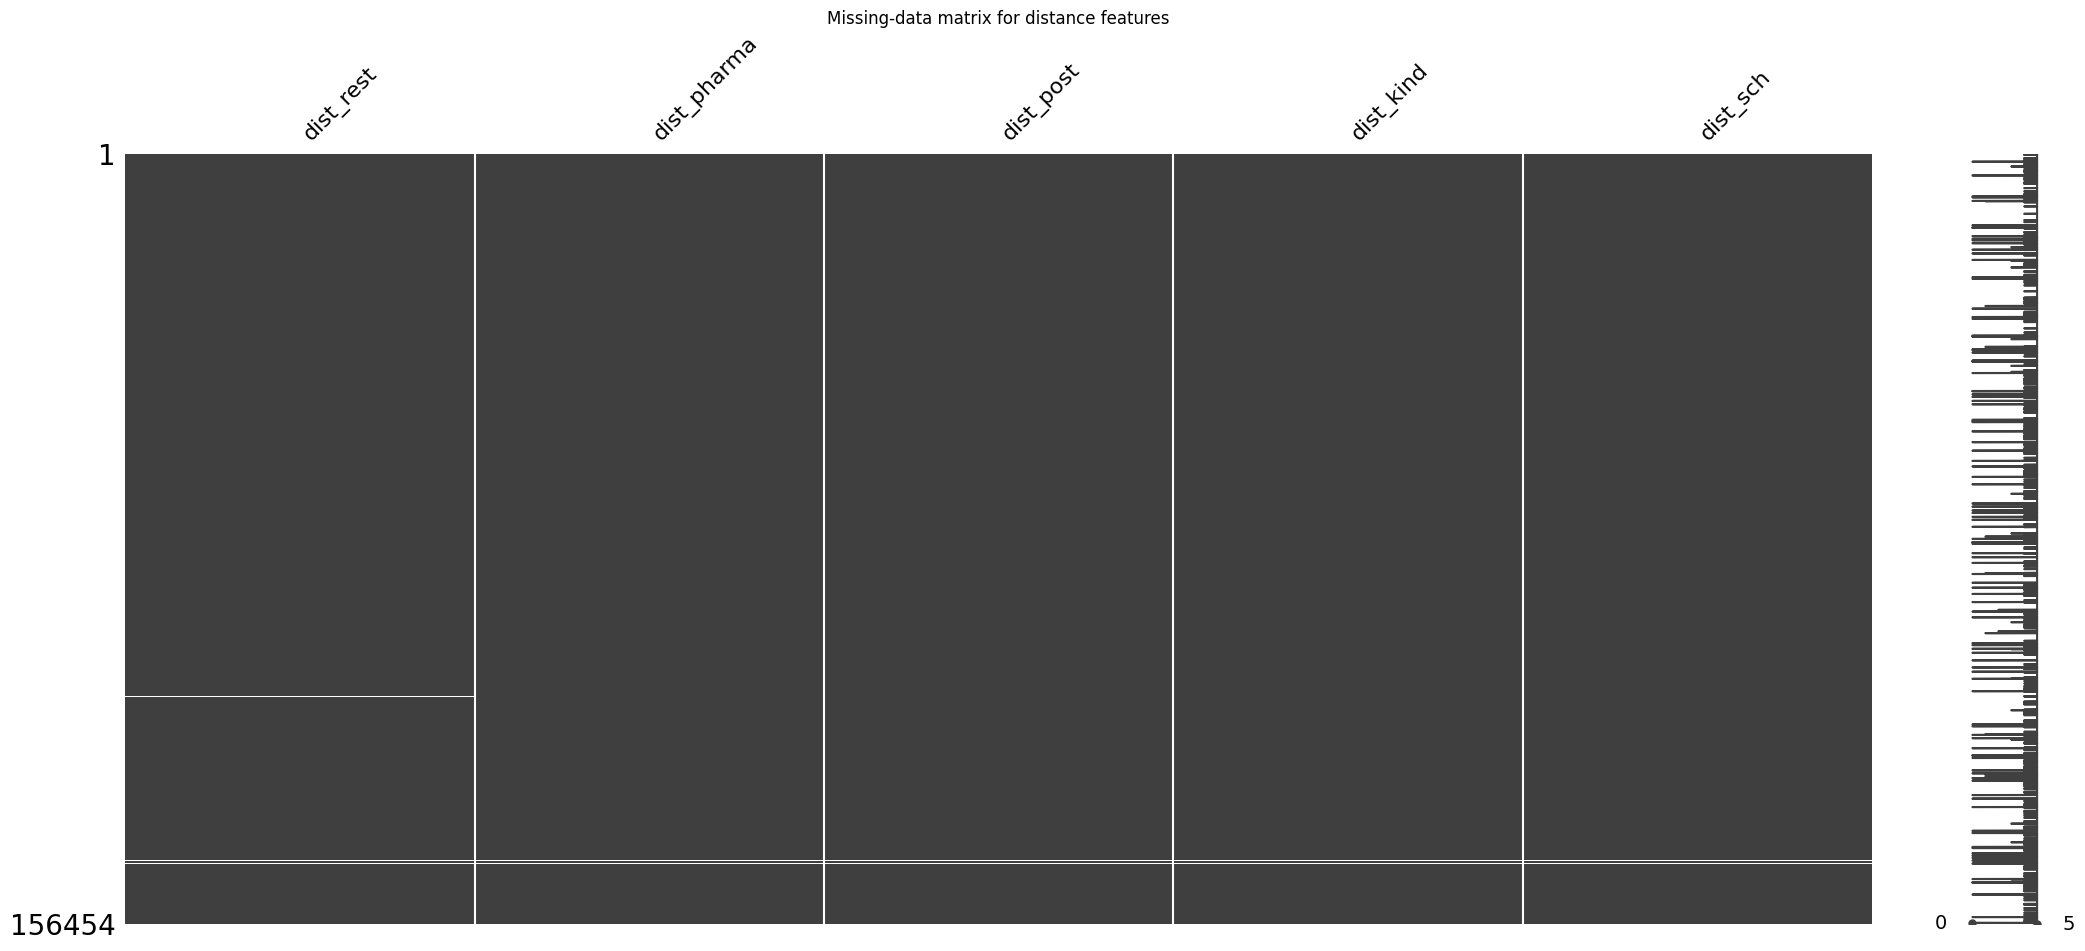

In [ ]:
# focus on the five distance features with missing values
dist_cols = ['dist_rest', 'dist_pharma', 'dist_post', 'dist_kind', 'dist_sch']

# a) simple matrix plot
plt.figure(figsize=(8, 4))
msno.matrix(df[dist_cols])
plt.title("Missing-data matrix for distance features")
plt.show()

<Figure size 600x500 with 0 Axes>

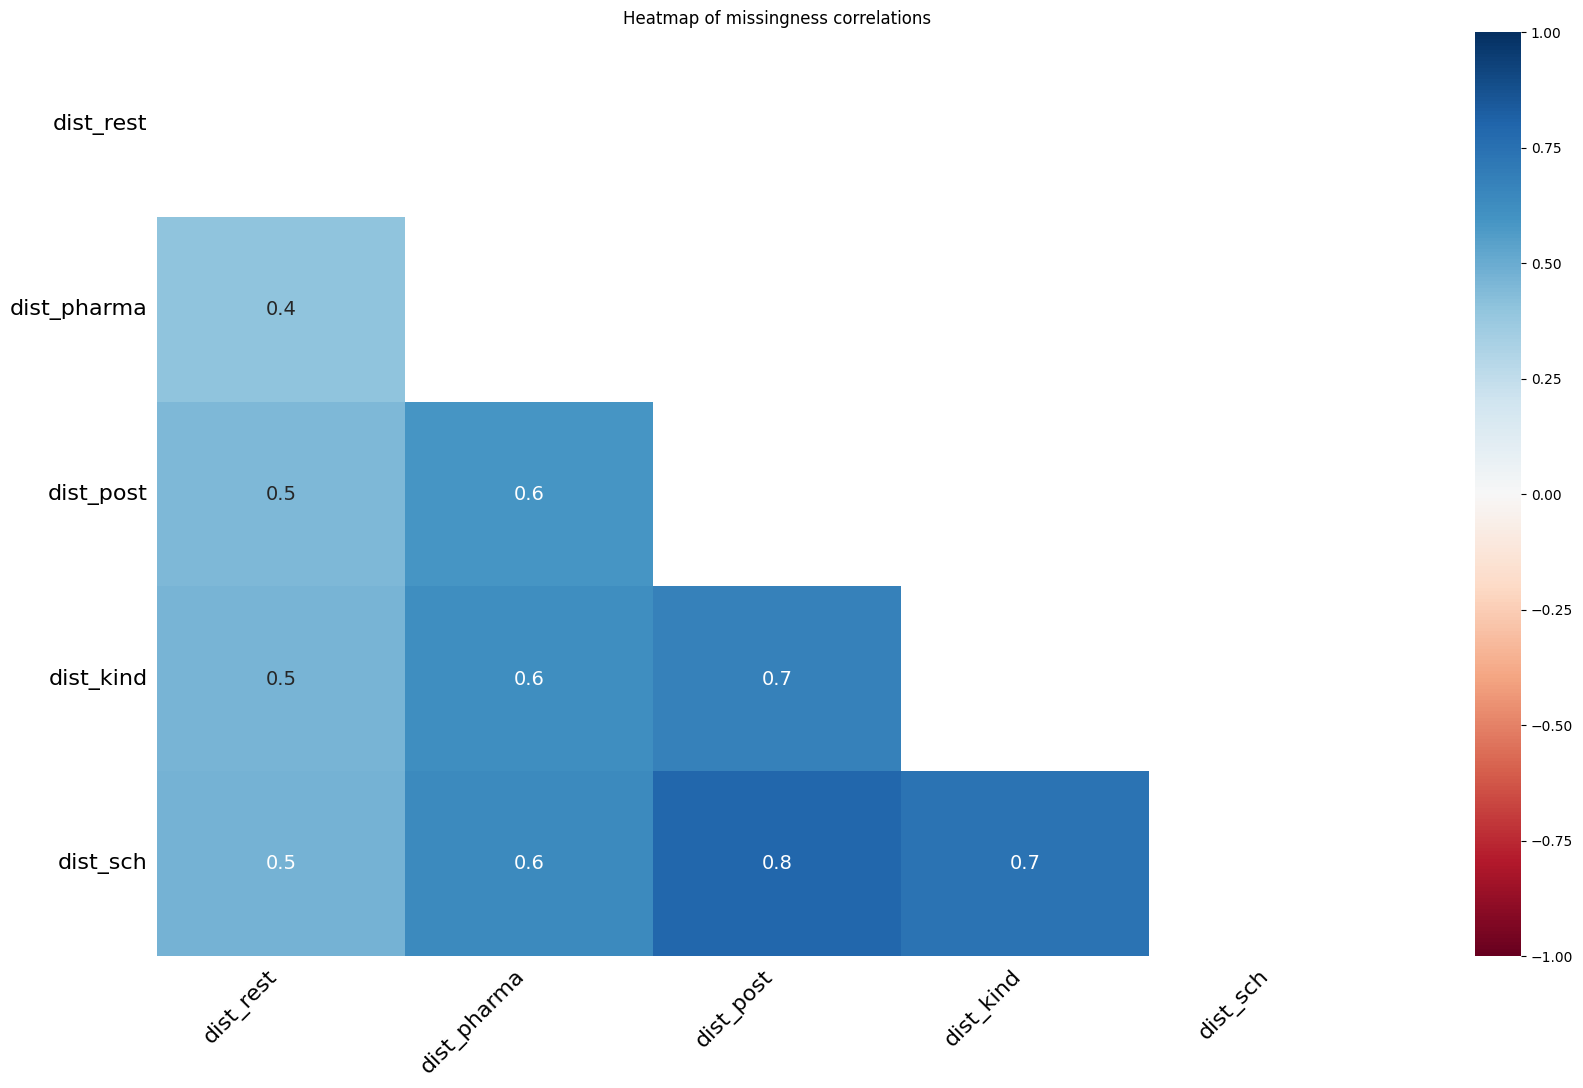

In [ ]:
# a heatmap of correlations among missingness patterns
plt.figure(figsize=(6, 5))
msno.heatmap(df[dist_cols])
plt.title("Heatmap of missingness correlations")
plt.show()

Block missingness – Those five distance features tend to drop out together (heatmap correlations up to 0.8), indicating a chunk of listings simply lack all POI-distance info.

### Quantify any bias in missing rows

In [174]:
mask = df[dist_cols].isna().any(axis=1)
print("Avg price_z with missing distances:", df.loc[mask, 'price_z'].mean())
print("Avg price_z with complete distances:", df.loc[~mask, 'price_z'].mean())

Avg price_z with missing distances: 981736.5384046054
Avg price_z with complete distances: 784039.751589197


Non-random bias – Rows with any missing distances have a much higher average price_z (~981 k vs. 784 k), so those are systematically pricier units.

### Missing-indicator +  fill with median

In [ ]:
other_numeric = [c for c in df.columns 
                 if c not in dist_cols + ['price_z','unit_id'] 
                 and df[c].dtype != 'object']

In [ ]:
# 4) If also other missing numerics (e.g. floor_no/floor_max), do the same:
imputer_num = SimpleImputer(strategy='median')
imputer_num.fit(df[other_numeric])


SimpleImputer(strategy='median')

In [177]:
df[other_numeric] = imputer_num.transform(df[other_numeric])
df_test[other_numeric]  = imputer_num.transform(df_test[other_numeric])

### outlier checks

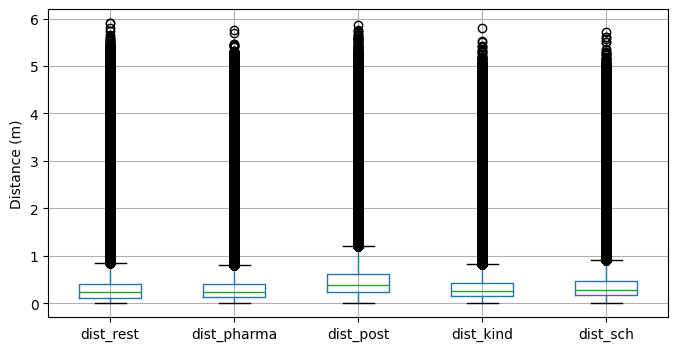

In [131]:
df[dist_cols].boxplot(figsize=(8,4))
plt.ylabel("Distance (m)")
plt.show()


These boxplots reveal two key things:

Heavy right-skew — nearly all listings are very close to the POIs, with a long tail of a few “far-out” apartments.

Lots of extreme outliers — points up near 5–6 units (meters? kilometers?) are pulling that whisker way up.

### log-transform approach

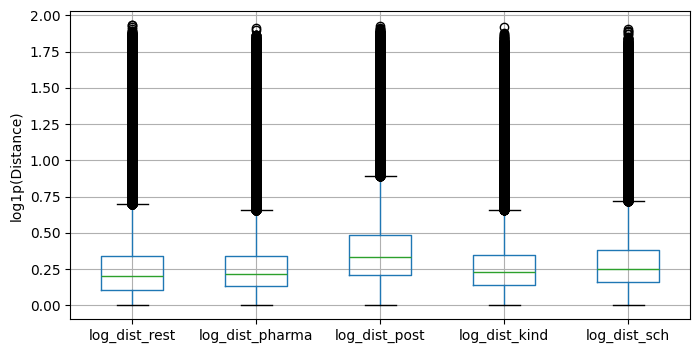

In [ ]:
# apply log1p to safely handle zeros
for col in dist_cols:
    df[f"log_{col}"] = np.log1p(df[col])


df[[f"log_{c}" for c in dist_cols]].boxplot(figsize=(8,4))
plt.ylabel("log1p(Distance)")
plt.show()


Now that I have tamed the skew in distance features with a log1p transform


### fit the pipeline on training set

In [178]:

print(df_test.isna().sum())


unit_id              0
dim_m2               0
n_rooms              0
floor_no             0
floor_max            0
                    ..
loc_code_81b10147    0
loc_code_8d5a4f0c    0
loc_code_a6d54bd1    0
loc_code_e0cff11b    0
loc_code_ece39f3d    0
Length: 62, dtype: int64


In [179]:

print(df.isna().sum())

unit_id              0
dim_m2               0
n_rooms              0
floor_no             0
floor_max            0
                    ..
loc_code_81b10147    0
loc_code_8d5a4f0c    0
loc_code_a6d54bd1    0
loc_code_e0cff11b    0
loc_code_ece39f3d    0
Length: 62, dtype: int64


### Scatterplots of each supplementary variable vs. price_z (targat variable)

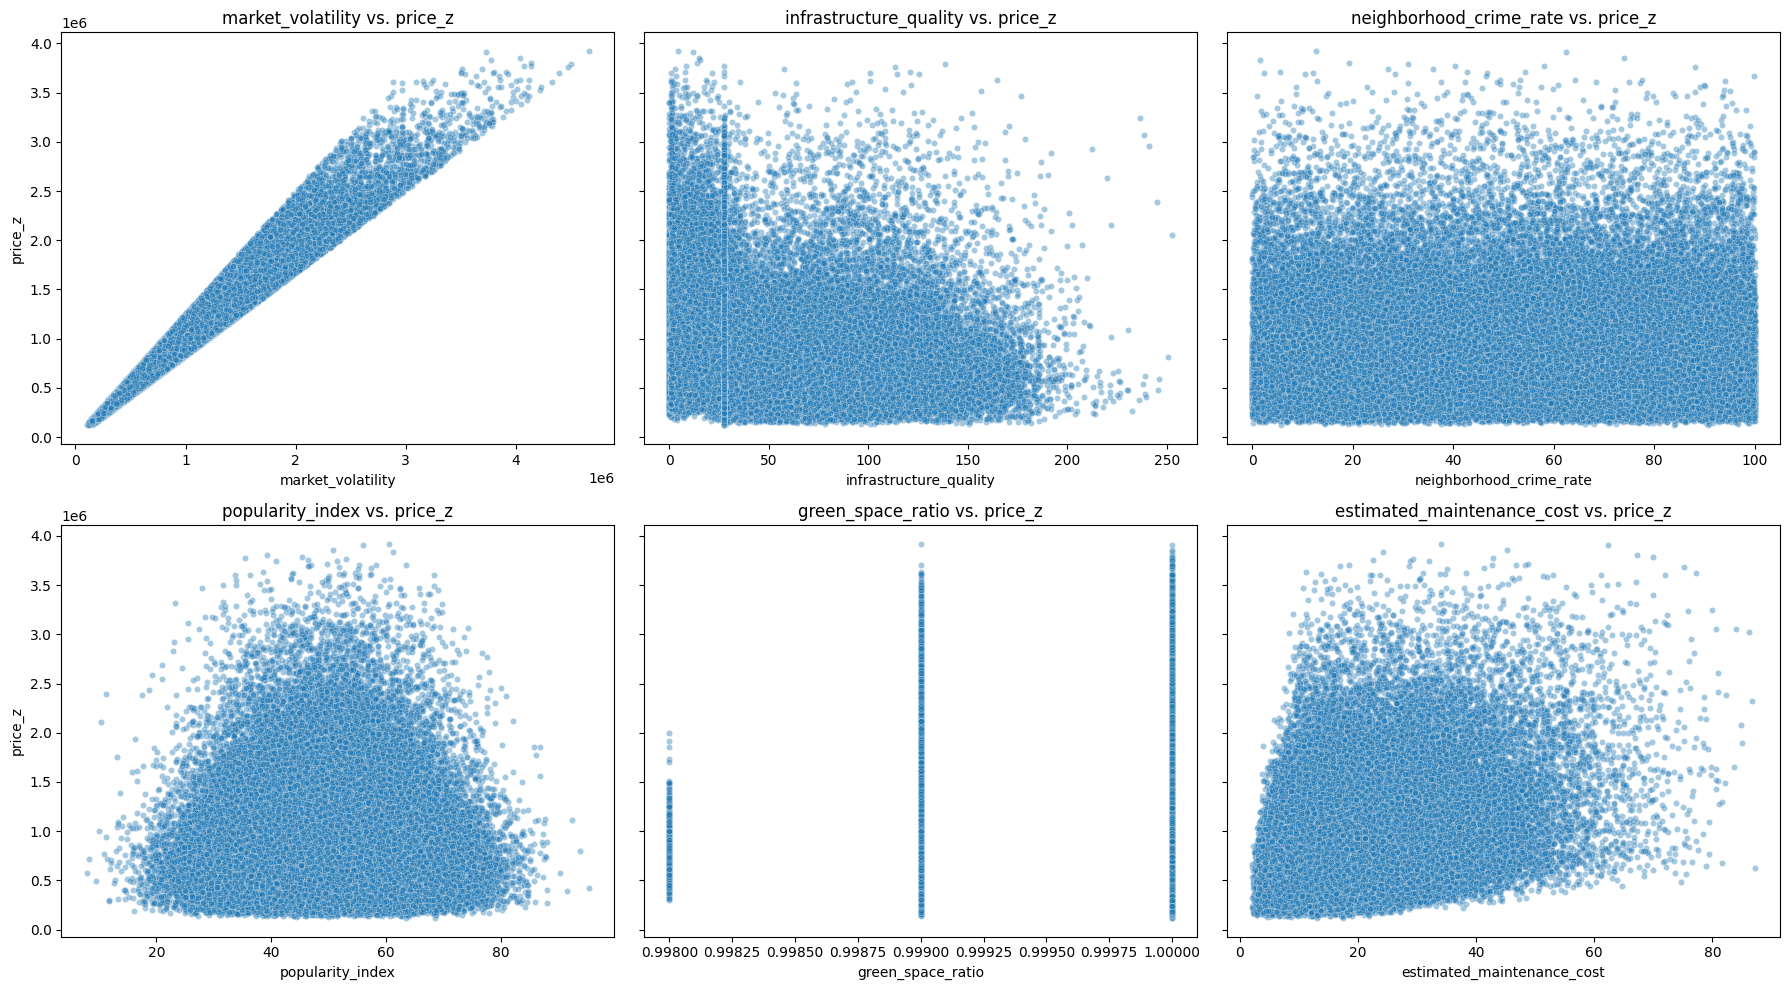

In [ ]:
supp_vars = [
    'market_volatility',
    'infrastructure_quality',
    'neighborhood_crime_rate',
    'popularity_index',
    'green_space_ratio',
    'estimated_maintenance_cost'
]

# create a 2-row, 3-col grid of axes
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10), sharey=True)
axes = axes.flatten()   # turn the 2×3 array into a flat list

for ax, var in zip(axes, supp_vars):
    sns.scatterplot(
        data=df,
        x=var,
        y='price_z',
        alpha=0.4,
        s=20,
        ax=ax           # draw each plot on its own subplot
    )
    ax.set_title(f"{var} vs. price_z")
    ax.set_xlabel(var)
    ax.set_ylabel("price_z")

plt.tight_layout()
plt.show()


### 🔍 Interpretation of Supplementary Scatterplots

* **market\_volatility vs. price\_z** 📈
  Almost a straight-line upward trend—apartments in more volatile markets tend to cost more, making this a very strong positive predictor.

* **infrastructure\_quality vs. price\_z** 🏗️
  No clear pattern (maybe even a slight downward drift)—once you control for the main features, infrastructure quality doesn’t move prices much.

* **popularity\_index vs. price\_z** 🌟
  A mild “inverted U” shape—apartments with **moderate** popularity scores fetch the highest prices, while very low or very high popularity relates to slightly lower prices.

* **neighborhood\_crime\_rate vs. price\_z** 🚨
  Essentially a cloud with no slope—crime rate shows **no** meaningful correlation with price in this dataset.

* **green\_space\_ratio vs. price\_z** 🌳
  Almost all points sit at \~1.0 with no visible trend—green space ratio varies so little here that it has virtually no impact.

* **estimated\_maintenance\_cost vs. price\_z** 💰
  Clear positive relationship with diminishing returns—higher maintenance costs go hand-in-hand with higher prices, but the effect tapers off at the top end.


### Univariate distributions (histogram + boxplot) for each supplementary variable

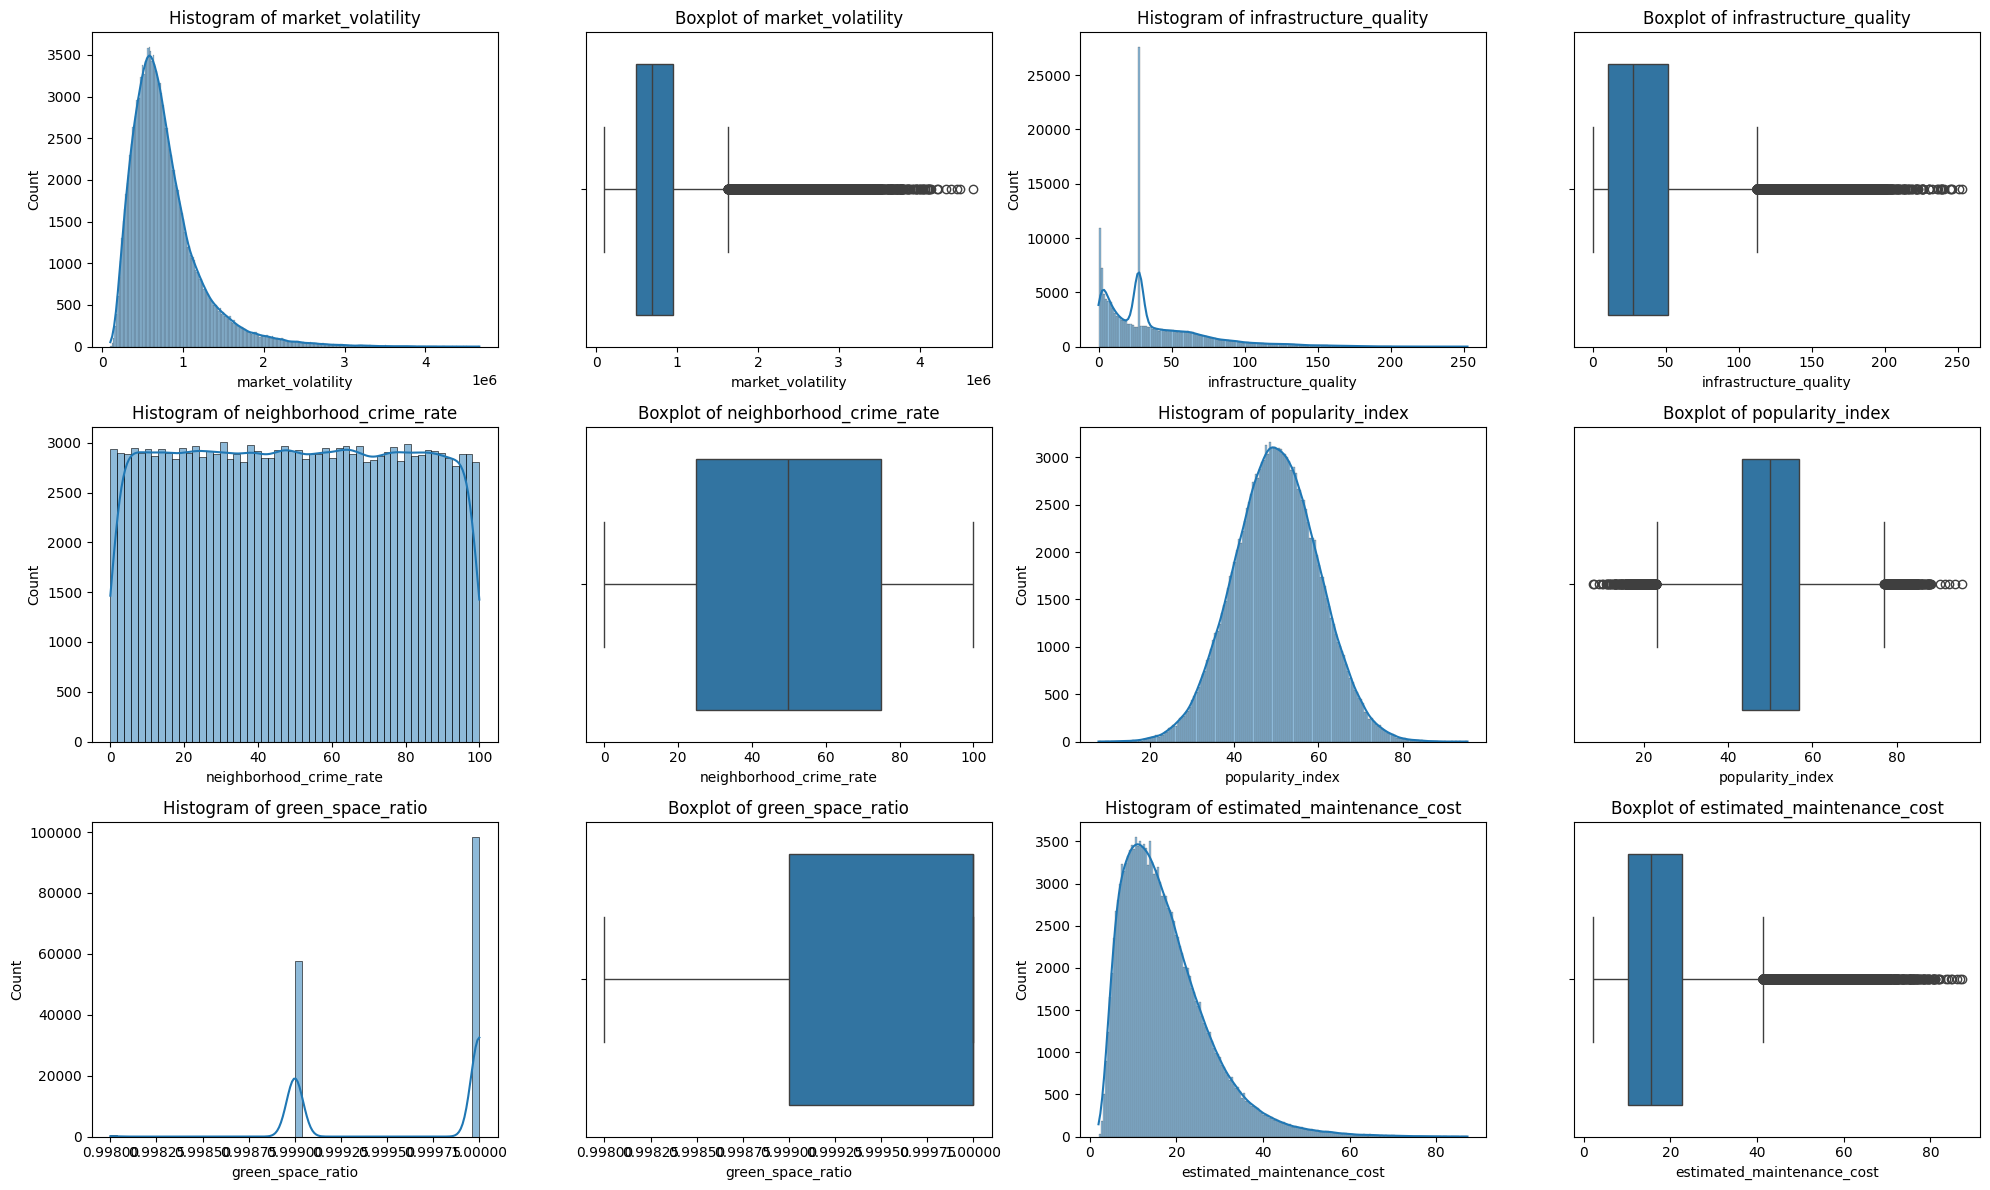

In [139]:
fig, axes = plt.subplots(3, 4, figsize=(20, 12))
axes = axes.flatten()

for i, var in enumerate(supp_vars):
    # hist goes in axes[2*i], box in axes[2*i+1]
    sns.histplot(df[var], kde=True, ax=axes[2*i])
    axes[2*i].set_title(f"Histogram of {var}")
    sns.boxplot(x=df[var], ax=axes[2*i+1])
    axes[2*i+1].set_title(f"Boxplot of {var}")

plt.tight_layout()
plt.show()


### 🔍 Univariate Distributions (Histogram + Boxplot)

* **market\_volatility** 📊

  * **Shape:** Strongly right-skewed—most values cluster at lower volatility, with a long tail up past 4 × 10⁶.
  * **Outliers:** Many high-volatility outliers beyond \~2 × 10⁶.

* **infrastructure\_quality** 🏗️

  * **Shape:** Heavily right-skewed—most scores are low (0–20), few very high values up to 250.
  * **Outliers:** Extreme high-quality points (150–250) sit well above the upper whisker.

* **neighborhood\_crime\_rate** 🚨

  * **Shape:** Nearly uniform from 0 % to 100 %—flat histogram, box covers almost the full range.
  * **Outliers:** Virtually none—crime rates are evenly spread.

* **popularity\_index** 🌟

  * **Shape:** Approximately bell-shaped, centered around \~50.
  * **Outliers:** A handful of very low (<20) or very high (>80) popularity scores.

* **green\_space\_ratio** 🌳

  * **Shape:** Two tight clusters near \~0.999 and 1.000—almost no variation.
  * **Outliers:** A small number of slightly lower ratios (\~0.998) below the main cluster.

* **estimated\_maintenance\_cost** 💰

  * **Shape:** Right-skewed—most costs between 0–30, tapering off toward \~80.
  * **Outliers:** Several expensive units (maintenance > 60) beyond the upper whisker.


### Flag & summarize outliers via IQR

In [ ]:
outlier_summary = []

for var in supp_vars:
    Q1 = df[var].quantile(0.25)
    Q3 = df[var].quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    
    mask = (df[var] < lower) | (df[var] > upper)
    n_out = mask.sum()
    pct_out = n_out / len(df) * 100
    
    # add a boolean column marking outliers
    df[f"{var}_outlier"] = mask
    
    outlier_summary.append({
        'variable': var,
        'n_outliers': n_out,
        'pct_outliers': round(pct_out, 2),
        'lower_bound': lower,
        'upper_bound': upper
    })


import pandas as pd
outlier_df = pd.DataFrame(outlier_summary)
print(outlier_df)


                     variable  n_outliers  pct_outliers  lower_bound  \
0           market_volatility        7827          5.00 -191954.5100   
1      infrastructure_quality        6809          4.35     -50.7000   
2     neighborhood_crime_rate           0          0.00     -50.1200   
3            popularity_index        1088          0.70      22.9900   
4           green_space_ratio           0          0.00       0.9975   
5  estimated_maintenance_cost        4569          2.92      -8.5150   

    upper_bound  
0  1.634946e+06  
1  1.125800e+02  
2  1.498800e+02  
3  7.707000e+01  
4  1.001500e+00  
5  4.136500e+01  


###  Cap (“winsorize”) at the IQR bounds

In [92]:
for var, lower, upper in zip(
    ['market_volatility','infrastructure_quality',
     'popularity_index','estimated_maintenance_cost'],
    outlier_df['lower_bound'], 
    outlier_df['upper_bound']
):
    # if lower is negative (like for market_volatility), just ignore it
    lower_cap = max(lower, df[var].min())
    df[var]      = df[var].clip(lower=lower_cap, upper=upper)
    df_test[var] = df_test[var].clip(lower=lower_cap, upper=upper)


### cheking ouliers after cap:

In [ ]:
outlier_summary = []

for var in supp_vars:
    Q1 = df[var].quantile(0.25)
    Q3 = df[var].quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    
    mask = (df[var] < lower) | (df[var] > upper)
    n_out = mask.sum()
    pct_out = n_out / len(df) * 100
    
    # add a boolean column marking outliers
    df[f"{var}_outlier"] = mask
    
    outlier_summary.append({
        'variable': var,
        'n_outliers': n_out,
        'pct_outliers': round(pct_out, 2),
        'lower_bound': lower,
        'upper_bound': upper
    })



outlier_df = pd.DataFrame(outlier_summary)
print(outlier_df)

                     variable  n_outliers  pct_outliers  lower_bound  \
0           market_volatility           0          0.00 -191954.5100   
1      infrastructure_quality           0          0.00     -50.7000   
2     neighborhood_crime_rate           0          0.00     -50.1200   
3            popularity_index        1088          0.70      22.9900   
4           green_space_ratio           0          0.00       0.9975   
5  estimated_maintenance_cost       37733         24.12      22.9900   

    upper_bound  
0  1.634946e+06  
1  1.125800e+02  
2  1.498800e+02  
3  7.707000e+01  
4  1.001500e+00  
5  2.299000e+01  


**37 733 outliers (24%) on estimated_maintenance_cost—that’s a red flag.**

### Winsorize at the 95th percentile

In [96]:
for var in ['estimated_maintenance_cost']:
    cap95 = df[var].quantile(0.95)
    df[var]      = df[var].clip(upper=cap95)
    df_test[var] = df_test[var].clip(upper=cap95)


In [ ]:
outlier_summary = []

for var in supp_vars:
    Q1 = df[var].quantile(0.25)
    Q3 = df[var].quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    
    mask = (df[var] < lower) | (df[var] > upper)
    n_out = mask.sum()
    pct_out = n_out / len(df) * 100
    
    # add a boolean column marking outliers
    df[f"{var}_outlier"] = mask
    
    outlier_summary.append({
        'variable': var,
        'n_outliers': n_out,
        'pct_outliers': round(pct_out, 2),
        'lower_bound': lower,
        'upper_bound': upper
    })


import pandas as pd
outlier_df = pd.DataFrame(outlier_summary)
print(outlier_df)

                     variable  n_outliers  pct_outliers  lower_bound  \
0           market_volatility           0          0.00 -191954.5100   
1      infrastructure_quality           0          0.00     -50.7000   
2     neighborhood_crime_rate           0          0.00     -50.1200   
3            popularity_index        1088          0.70      22.9900   
4           green_space_ratio           0          0.00       0.9975   
5  estimated_maintenance_cost       37733         24.12      22.9900   

    upper_bound  
0  1.634946e+06  
1  1.125800e+02  
2  1.498800e+02  
3  7.707000e+01  
4  1.001500e+00  
5  2.299000e+01  


I was not successful to remove 24% outliers in estimated_maintenance_cost  

# Save the final data as a pickle

In [181]:
import pickle

# Save the prepared train and test DataFrames to a single pickle file
with open("/Users/majid/Documents/second semester/machine learning /_assessment_project/apartment_prepared.pkl", "wb") as f:
    pickle.dump(df, f)
    pickle.dump(df_test, f)
    

# Verify that the file was created
import os
os.path.exists("/Users/majid/Documents/second semester/machine learning /_assessment_project/apartment_prepared.pkl")




True

## Conclusion & Next Steps

We have successfully cleaned and preprocessed the dataset:

- **Missing data** were imputed using median or mode strategies depending on variable type.  
- **Categorical variables** were one-hot encoded (changed to binary), and **numeric variables** were scaled to mean zero, unit variance.  
- **Feature transformations** (e.g. log and polynomial terms) were applied where needed to reduce skew and capture nonlinearity.  
- The final DataFrame has been split into training and validation subsets, preserving the target distribution.

**Next steps:**

 
2. **Feature selection**: Use regularization or tree-based importance metrics to prune irrelevant predictors.  


**Limitations that will cover in next notebook:**

- We have not yet addressed potential multicollinearity among related features.  
- Outlier detection and robust regression techniques remain to be explored. 
